# NPQ model

Model of non-photochemical quenching in plants implementded in modelbase version 1.0 (see Matuszyńska, A., Heidari, S., Jahns, P., Ebenhöh, O., 2016. A mathematical model of non-photochemical quenching to study short-term light memory in plants. Biochimica et Biophysica Acta (BBA) - Bioenergetics 1857, 1860–1869. https://doi.org/10.1016/j.bbabio.2016.09.003)
 

In [1]:
%matplotlib notebook

In [2]:
#!conda list

## Import packages

In [3]:
import numpy as np
from modelbase.ode import Model, Simulator
import matplotlib.pyplot as plt

plt.style.use('ggplot')

Could not find GLIMDA


## Parameter set

In [4]:
#Comments from original implementation by Matuszynska et al 2016

pars = {
            
    #Pool sizes 
    'PSIItot': 2.5,  # [mmol/molChl] total concentration of PSII        
    'PQtot': 20,     # [mmol/molChl]      
    'APtot': 50,     # [mmol/molChl] Bionumbers ~2.55mM (=81mmol/molChl)      
    'Lhcxtot': 1,    # [relative] LHCs that get phosphorylated and protonated       
    'Xtot': 1,       # [relative] xanthophylls     
    'O2ex': 8,       # external oxygen, kept constant, corresponds to 250 microM, corr. to 20%      
    'Pi': 0.01,             
            
    #Rate constants and key parameters
    'kCytb6f': 0.104,           # a rough estimate of the transfer from PQ to cyt that is equal to ~ 10ms
                                # [1/s*(mmol/(s*m^2))] - gets multiplied by light to determine rate
    'kActATPase': 0.01,        # paramter relating the rate constant of activation of the ATPase in the light
    'kDeactATPase': 0.002,     # paramter relating the deactivation of the ATPase at night
    'kATPsynthase': 20.,
    'kATPconsumption': 10.,
    'kPQred': 250.,            # [1/(s*(mmol/molChl))]
    'kH0':5e8,
    'kH': 5e9,
    'kF': 6.25e8,              # fluorescence 16ns
    'kP': 1.2e9,                 # original 5e9 (charge separation limiting step ~ 200ps) - made this faster for higher Fs fluorescence
    'kPTOX': 0.00,             # CHANGED for the DIATOMS, no evidence of PTOX presence
    'pHstroma': 7.8,           # [1/s] leakage rate
    'kleak': 1000.,
    'bH': 100,                 # proton buffer: ratio total / free protons
    'HPR': 14./3.,
            
    #Parameter associated with xanthophyll cycle
    'kDeepox': 0.01,
    'kEpox': 0.006,   # 6.e-4,  #converted to [1/s]
    'KphSatZ': 5.8,      # [-] half-saturation pH value for activity de-epoxidase, highest activity at ~pH 5.8
    'nHX': 5.,           # [-] hill-coefficient for activity of de-epoxidase
    'Kzsat': 0.12,       # [-], half-saturation constant (relative conc. of Z) for quenching of Z
            
    #Parameter associated with PsbS protonation
    'nHL': 3,
    'kDeprot': 0.0096,
    'kProt': 0.0096,
    'KphSatLHC': 5.8,
            
    #Fitted quencher contribution factors
    'gamma0': 0.05,   # slow quenching of Vx present despite lack of protonation
    'gamma1': 0.25,  # fast quenching present due to the protonation
    'gamma2': 0.6,   # slow quenching of Zx present despite lack of protonation
    'gamma3': 0.15,  # fastest possible quenching
            
    #Physical constants
    'F': 96.485,  # Faraday constant
    'R': 8.3e-3,  # universal gas constant
    'T': 298,     # Temperature in K - for now assumed to be constant at 25 C
            
    #Standard potentials and DG0ATP
    'E0QAQAm': -0.140,
    'E0PQPQH2': 0.354,
    'E0PCPCm': 0.350,  # CHANGED for the DIATOMS
    'DG0ATP': 30.6,  # 30.6kJ/mol / RT
            
    #PFD
    'pfd': 100

            }

## pH and cpfd functions

In [5]:
def calculate_pHstroma(x):
    return (-np.log(x*(3.2e-5))/np.log(10))    

def calculate_pHinv(x):
    return (3.125e4 * 10 **(-x))

def calculate_pH(H):
    "assumed bigger lumen by changing the volume"
    return -np.log10(H*3.2e-5)

## Model initialization and compounds

In [6]:
# define the basic model 
M16model = Model(pars)

# add compounds 
M16model.add_compounds([
    "P", # reduced Plastoquinone
    "H", # luminal Protons
    "E", # ATPactivity
    "A", # ATP
    "Lhcx", # fraction of non-protonated LHCX (L + Lp = Ltot)
    "Dd" # fraction of epoxidised xantohylls (Dd + Dt = Xtot)
    ])

## Derived parameters

In [7]:
M16model.add_derived_parameter(
    parameter_name="RT", function=lambda r, t: r * t, parameters=["R", "T"])

def _KeqQAPQ(F, E0QAQAm, E0PQPQH2, pHstroma, RT):
    DG1 =  -F*E0QAQAm 
    DG2 = -2*F*E0PQPQH2 + 2*pHstroma * np.log(10) * RT 
    DG0 = -2*DG1 + DG2
    Keq = np.exp(-DG0/RT)
    return Keq

M16model.add_derived_parameter(
    parameter_name = "KeqQAPQ", function=_KeqQAPQ, parameters=["F", "E0QAQAm", "E0PQPQH2", "pHstroma", "RT"])

## Auxiliary functions

In [8]:
def ps2states(P, Q, light, PQtot, kPQred, KeqQAPQ, kH, kF, kP, PSIItot):
    """Calculates the states of photosystem II
    
    accepts:
    P: reduced fraction of PQ pool (PQH2)
    Q: Quencher
    
    returns:
    B: array of PSII states
    """
    
    Bs = []
    Pox = PQtot - P
    b0 = (light + kPQred*P/KeqQAPQ)
    b1 = (kH * Q + kF)
    b2 = kH * Q + kF + kP
    
    for Pox,b0,b1,b2 in zip(Pox,b0,b1,b2):
        A = np.array([
        [-b0,        b1,         kPQred*Pox,                0], #B0
        [light,     -b2,         0,                         0], #B1
        [0,          0,          light,                   -b1], #B3
        [1,          1,          1,                         1]
        ])
        
        b = np.array([0,0,0,PSIItot])
        B0,B1,B2,B3 = np.linalg.solve(A,b)
        Bs.append([B0, B1, B2, B3])
    return np.array(Bs).T


def Keqcytb6f(H, F, E0PQPQH2, RT, E0PCPCm, pHstroma):
    """Equilibriu constant of Cytochrome b6f"""
    DG1 = -2*F*E0PQPQH2 + 2 * RT * np.log(10) * calculate_pH(H)
    DG2 = -F*E0PCPCm
    DG3 = RT*np.log(10)*(pHstroma - calculate_pH(H))
    DG = -DG1 + 2*DG2 + 2*DG3
    Keq = np.exp(-DG/RT)
    return Keq
    
    
def KeqATPsyn(H, DG0ATP, pHstroma, RT, Pi):
    """Equilibrium constant of ATP synthase. For more
    information see Matuszynska et al 2016 or Ebenhöh et al. 2011,2014
    """
    DG = DG0ATP - np.log(10) * (pHstroma-calculate_pH(H)) * (14/3)  * RT
    Keq = Pi * np.exp(-DG/RT) 
    return Keq

def Fluorescence(P, Q, B0, B2, light, PQtot, kPQred, KeqQAPQ, kH, kF, kP, PSIItot):
    """Fluorescence function"""
    Fluo =  kF/(kH*Q+kF+kP) * B0 + kF/(kH*Q+kF) * B2
    return Fluo

def Quencher(Lhcx, Dd, Xtot, Lhcxtot, Kzsat, gamma0, gamma1, gamma2, gamma3):
    """Quencher mechanism
    
    accepts: 
    Pr: fraction of non-protonated PsbS protein
    V: fraction of Violaxanthin
    """
    Dt = Xtot - Dd
    P = Lhcxtot - Lhcx
    #Zs = Z #Z/(Z +  Kzsat)
        
    Q = Dt * P / (P + Kzsat) 
    #gamma0 * (1-Zs) * Pr + gamma1 * (1-Zs) * P + gamma2 * Zs * P + gamma3 * Zs * Pr
    return Q

## Conserved quantities

In [9]:
def pqmoiety(P, PQtot):
    return [PQtot - P]

def atpmoiety(A, APtot):
    return [APtot - A]

def psbsmoiety(Pr, PsbStot):
    return [PsbStot - Pr]

def xcycmoiety(X, Xtot):
    return [Xtot - X]

# Rate equations

In [10]:
def vps2(B1, light, PQtot, kPQred, KeqQAPQ, kH, kF, kP, PSIItot): 
    """Reduction of PQ due to ps2"""
    v = kP * 0.5 * B1
    return v

    
    
def vPQox(P, H, light, kCytb6f, kPTOX, O2ex, PQtot, F, E0PQPQH2, RT, E0PCPCm, pHstroma):
    """Oxidation of the PQ pool through cytochrome and PTOX"""
    kPFD = kCytb6f * light
    kPTOX = kPTOX * O2ex 
    Keq = Keqcytb6f(H, F, E0PQPQH2, RT, E0PCPCm, pHstroma)
    a1 = kPFD * Keq/ (Keq + 1)  
    a2 = kPFD/(Keq + 1)
    v = (a1 + kPTOX) * P - a2 * (PQtot - P)
    return v
    
    
def vATPsynthase(A, H, E, kATPsynthase, DG0ATP, pHstroma, RT, Pi, APtot):
    """Production of ATP by ATPsynthase"""
    v = E * kATPsynthase * (APtot - A - A/KeqATPsyn(H, DG0ATP, pHstroma, RT, Pi))
    return v
    
    
def vATPactivity(E, light,  kActATPase,  kDeactATPase):
    """Activation of ATPsynthase by light"""
    switch = light > 0
    v = kActATPase * switch * (1 - E) - kDeactATPase * (1-switch) * E
    return v
    
    
def vLeak(H, kleak, pHstroma):
    """Transmembrane proton leak"""
    v = kleak * (H - calculate_pHinv(pHstroma))
    return v
    
    
def vATPcons(A, kATPconsumption):
    """ATP consuming reaction"""
    v = kATPconsumption * A
    return v
    
    
def vXdeepox(X, H, nHX, KphSatZ, kDeepoxV, kEpoxZ):
    """Xanthophyll cycle"""
    a = H**nHX / (H**nHX + calculate_pHinv(KphSatZ)**nHX)
    v = kDeepoxV * a * X
    return v

def vXepox(X, Xtot, kEpox):
    return kEpox * (Xtot - X)   
    
    
def vLHCXprot(P, H, nHL, KphSatLHC, kProt):
    """Protonation of PsbS protein"""
    a = H**nHL / (H**nHL + calculate_pHinv(KphSatLHC)**nHL)
    v = kProt * a * P
    return v

def vLHCXdeprot(P, Lhcxtot, kDeprot):
    """Protonation of PsbS protein"""
    return kDeprot * (Lhcxtot - P)


## Algebraic modules

In [11]:
M16model.add_algebraic_module(
    module_name="calculate_pH",
    function=calculate_pH,
    compounds=["H"],
    derived_compounds=["pH"],
    modifiers=None
)



M16model.add_algebraic_module(
    module_name = "P_am",
    function = pqmoiety,
    compounds = ["P"],
    derived_compounds = ["Pox"],
    parameters = ["PQtot"])


M16model.add_algebraic_module(
    module_name = "A_am",
    function = atpmoiety,
    compounds = ["A"],
    derived_compounds = ["ADP"],
    parameters = ["APtot"])


M16model.add_algebraic_module(
    module_name = "LHCX_am",
    function = psbsmoiety,
    compounds = ["Lhcx"],
    derived_compounds = ["Lhcxp"],
    parameters = ["Lhcxtot"])


M16model.add_algebraic_module(
    module_name = "X_am",
    function = xcycmoiety,
    compounds = ["Dd"],
    derived_compounds = ["Dt"],
    parameters = ["Xtot"])


M16model.add_algebraic_module(
    module_name = "Quencher",
    function = Quencher,
    compounds = ["Lhcx", "Dd"],
    derived_compounds = ["Q"],
    parameters = ["Xtot", "Lhcxtot", "Kzsat",
                  "gamma0", "gamma1", "gamma2",
                  "gamma3"])


M16model.add_algebraic_module(
    module_name = 'PSIIstates',
    function = ps2states,
    compounds = ["P", "Q"],
    derived_compounds = ["B0", "B1", "B2", "B3"],
    parameters = ["pfd", "PQtot", "kPQred",
                  "KeqQAPQ", "kH", "kF", "kP", "PSIItot"])


M16model.add_algebraic_module(
    module_name = "Fluorescence",
    function = Fluorescence,
    compounds = ["P", "Q", "B0", "B2"],
    derived_compounds = ["Fluo"],
    parameters = ['pfd', 'PQtot', 'kPQred', 'KeqQAPQ',
                  'kH', 'kF', 'kP', 'PSIItot'])

# Mock module to get Light vector over all simulated time points
#M16model.add_algebraic_module(
#    module_name = "L",
#    function = lambda X, PFD: PFD ,
#    compounds = ["P"],
#    derived_compounds = ["L"],
#    parameters = ['PFD'])

## Add reactions

In [12]:
M16model.add_reaction(
        rate_name = "vps2",
        function = vps2,
        dynamic_variables=["B1"],
        stoichiometry = {"P":1,"H":2/pars["bH"]},
        parameters = ["pfd","PQtot","kPQred", "KeqQAPQ",
                      "kH", "kF", "kP", "PSIItot"])


M16model.add_reaction(
        rate_name = "vPQox",
        function = vPQox,
        dynamic_variables = ['P','H'],
        stoichiometry = {"P":-1,"H":4/pars["bH"]},
        parameters = ["pfd", "kCytb6f", "kPTOX", "O2ex",
                          "PQtot", "F", "E0PQPQH2", "RT", "E0PCPCm",
                          "pHstroma"])

    
M16model.add_reaction(
        rate_name = "vATPsynthase",
        function = vATPsynthase,
        dynamic_variables = ["A","H","E"],
        stoichiometry = {"A":1, "H": (-14/3)/pars["bH"]},
        parameters = ["kATPsynthase", "DG0ATP", "pHstroma",
                      "RT", "Pi", "APtot"])
    
    
M16model.add_reaction(
        rate_name = "vATPactivity",
        function = vATPactivity,
        dynamic_variables = ["E"],
        stoichiometry = {"E":1},
        parameters = ["pfd",  "kActATPase",  "kDeactATPase"])


M16model.add_reaction(
        rate_name = "vLeak",
        function  = vLeak,
        stoichiometry = {"H": -1/pars["bH"]},
        parameters = ["kleak", "pHstroma"])


M16model.add_reaction(
        rate_name = "vATPcons",
        function = vATPcons,
        stoichiometry = {"A":-1},
        parameters = ["kATPconsumption"])


M16model.add_reaction(
        rate_name = "vXdeepox",
        function = vXdeepox,
        dynamic_variables = ['Dd','H'],
        stoichiometry = {"Dd": -1},
        parameters = ["nHX", "KphSatZ", "kDeepox",
                      "kEpox"])

M16model.add_reaction(
        rate_name = "vXepox",
        function = vXepox,
        dynamic_variables = ['Dd'],
        stoichiometry = {"Dd": 1},
        parameters = ["Xtot",
                      "kEpox"])

M16model.add_reaction(
        rate_name = "vLHCXprot",
        function = vLHCXprot,
        dynamic_variables = ["Lhcx", "H"],
        stoichiometry = {"Lhcx": -1},
        parameters = ["nHL", "KphSatLHC", "kProt"])

M16model.add_reaction(
        rate_name = "vLHCXdeprot",
        function = vLHCXdeprot,
        dynamic_variables = ["Lhcx"],
        stoichiometry = {"Lhcx": 1},
        parameters = ["Lhcxtot",
                      "kDeprot"])

M16model.add_algebraic_module(
    module_name = "L",
    function = lambda X, PFD: PFD ,
    compounds = ["P"],
    derived_compounds = ["L"],
    parameters = ['pfd'])


In [13]:
M16model.get_stoichiometric_df()

vATPactivity  vATPcons  vATPsynthase  vLHCXdeprot  vLHCXprot  vLeak  \
A              0.0      -1.0      1.000000          0.0        0.0   0.00   
Dd             0.0       0.0      0.000000          0.0        0.0   0.00   
E              1.0       0.0      0.000000          0.0        0.0   0.00   
H              0.0       0.0     -0.046667          0.0        0.0  -0.01   
Lhcx           0.0       0.0      0.000000          1.0       -1.0   0.00   
P              0.0       0.0      0.000000          0.0        0.0   0.00   

      vPQox  vXdeepox  vXepox  vps2  
A      0.00       0.0     0.0  0.00  
Dd     0.00      -1.0     1.0  0.00  
E      0.00       0.0     0.0  0.00  
H      0.04       0.0     0.0  0.02  
Lhcx   0.00       0.0     0.0  0.00  
P     -1.00       0.0     0.0  1.00

# Fv/Fm
For diatoms between 0.6 and 0.7

In [14]:
y0 =  {"P": 10., "H": 5.56305280e-04, "E": 0., "A": 1., "Lhcx": 1., "Dd": 1.}
Q = M16model.get_full_concentration_dict(y0)['Q']
fvfm = M16model.get_parameter('kP')/(M16model.get_parameter('kF') + M16model.get_parameter('kP') + M16model.get_parameter('kH')*Q)
print(Q, fvfm)

[0.] [0.65753425]


<IPython.core.display.Javascript object>


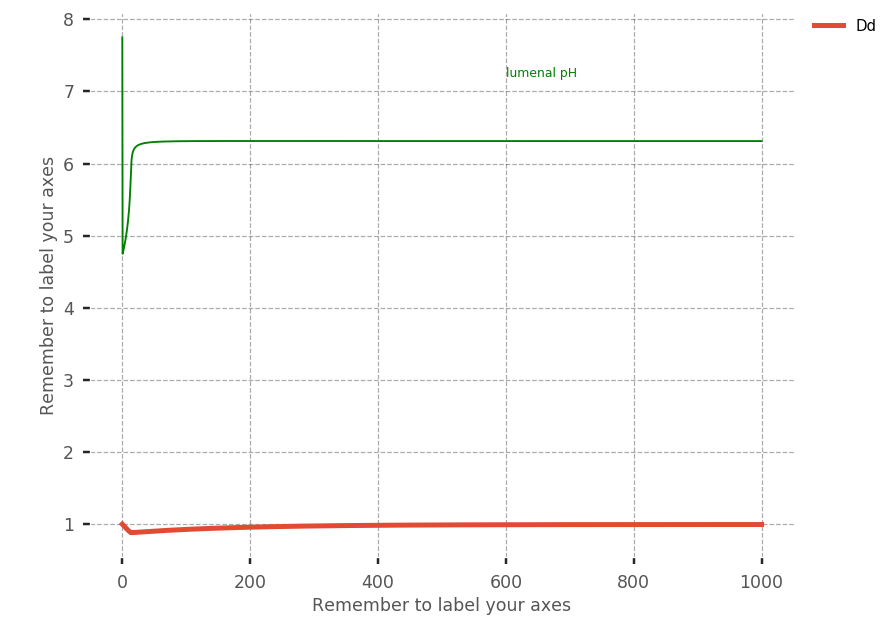

<IPython.core.display.Javascript object>

In [15]:
#y0 =  {"P": 10., "H": 5.56305280e-04, "E": 0., "A": .1, "Pr": .9, "X": .9}

s = Simulator(M16model)
s.initialise(y0)
s.update_parameter('pfd', 125.)
s.simulate(1000, steps=2000, **{"atol":1e-8})


s.plot_selection(['Dd'])
plt.plot(s.get_time(), s.get_variable('pH'), 'g')
ax = plt.gca()
ax.annotate('lumenal pH', xy=(600, 7.2), color='g')
s.plot_fluxes('vXcyc')

y0d = s.get_results_array()[-1]

In [16]:
plt.figure()
for ll in [30, 50, 65, 100, 250, 500, 750, 1000, 1500, 2000]:
    print(ll)
    s = Simulator(M16model)
    s.initialise(y0d)
    s.update_parameter('pfd', ll)
    s.simulate(50000)
    plt.plot(ll, (s.get_variable('Dt')[-1]), 'ro')
plt.xlabel('Light intensity ($\mu$mol photons.m${^-2}$.s$^{-1}$)')
plt.ylabel('De-epoxidation state (%)')

<IPython.core.display.Javascript object>

30
50
65
100
250
500
750
1000
1500
2000


Text(0, 0.5, 'De-epoxidation state (%)')

# Calculate NPQ

In [17]:
def get_NPQ(F, t, lights, maxlight=5000):
    r"""Extracts important points of the PAM simuations.

    get_NPQ calculates important points of the PAM simulation such as Fm, Fm', Ft', Fo
    Moreover, the NPQ values are calcuated.

    Parameters
    ----------
    F : numpy.array or list
        Simulated fluorescence values of PAM experiment
    t : numpy.array or list
        Time points of simulated PAM experiment
    lights : numpy.array or list
        PFD values for each time point
    maxlight : int 
       PFD of saturating light impuls
    

    Returns
    -------
    Fm : list
        Fm (first element of list) and Fm' values
    NPQ : list
        Calculated NPQ values
    tm : list
        Exact time points of peaks in PAM trace
    Fo : list
        Fo (first element of list) and Ft' values
    to : list
        Exact time points of Fo and Ft' values
     
    """
    z = [] #container for lists. Each list contains the positions of fluorescence values for one peak 
    o = [] #container for position of Fo'
    cnt = 0
    while cnt < len(lights):
        if lights[cnt] == maxlight:
            h = [] #temporary container for all F==maxlight. For each peak it is renewed
            while cnt != len(lights) and lights[cnt] == maxlight:
                h.append(cnt)
                cnt += 1
            z.append(h)
            o.append(h[0]-1) #value directly at the bottom of peak is Fo
        else:
            cnt += 1
    peaks = [i[np.argmax(F[i])] for i in z] #Fm is the maximal value for each peak sequence
    Fm = F[peaks]
    tm = t[peaks]
    Fo = F[o]
    to = t[o]
    NPQ = (Fm[0] - Fm)/Fm
    return Fm, NPQ, tm, Fo, to   

In [18]:
pfd = 250
#y0 =  {"P": 10., "H": 5.56305280e-04, "E": 0., "A": .1, "Pr": 1., "X": 1.}


s = Simulator(M16model)
s.initialise(y0)


dT = 15
t = 0
while t < 60 :   
    #turn on the saturating pulse of light of Tflash length
    if t%dT == 0:
        s.update_parameter('pfd', 10000)
        s.simulate(t+0.8, steps=100)
    else:
        #switch on the light except for the dark period
        s.update_parameter('pfd', pfd)
        new_t = t+dT-0.8
        s.simulate(new_t, steps=dT, **{"atol":1.0e-10})  #I needed to make it smaller from the default, otherwise integration problems  
    t = s.get_time()[-1]   

Tmax=15*60
dT = 30
while t < Tmax :   
    #turn on the saturating pulse of light of Tflash length
    if t%dT == 0:
        s.update_parameter('pfd', 10000)
        s.simulate(t+0.8, steps=100)
    else:
        #switch on the light except for the dark period
        #t+dT-Tflash is the time to the next flash
        if t<7*60: #or (t> 16*60 and t<25*60):
            #put the actinic light
            s.update_parameter('pfd', pfd)            
        else:
            s.update_parameter('pfd', 30.)
        new_t = t+dT-0.8
        s.simulate(new_t, steps=dT, **{"atol":1.0e-10})  #I needed to make it smaller from the default, otherwise integration problems  
    t = s.get_time()[-1]           

# Needs to be normalized s.plot_selection('Fluo')
F = s.get_variable('Fluo')
Fm, NPQ, tm, Fo, to = get_NPQ(s.get_variable('Fluo'), s.get_time(), s.get_variable('L'), 10000)

In [19]:
#Plots
plt.figure()
ax1=plt.subplot(221)
plt.plot(s.get_time()/60., F/max(F))
plt.plot(tm/60.,Fm[0:]/max(F),'o')
plt.plot(to/60.,Fo/max(F),'o')
plt.ylim(0, 1.05)
plt.xlabel('Time [s]')
plt.ylabel('Fluorescence [a.u.]')

fig2 = plt.subplot(222, sharex=ax1)
plt.plot(tm/60.,NPQ/2.5,'o-')
plt.xlabel('Time [s]')
plt.ylabel('NPQ [a.u.]')



fig3 = plt.subplot(223)
plt.plot(s.get_time()/60., s.get_variable('Dt'), label='Dt')
plt.plot(s.get_time()/60., s.get_variable('Lhcx'), label='Lhcx')
plt.plot(s.get_time()/60., s.get_variable('Q'), label ='Q')
plt.xlabel('Time [s]')
plt.ylabel('Concentration of Dt')
plt.legend()

fig4 = plt.subplot(224, sharex=fig3)
plt.plot(s.get_time()/60., s.get_variable('pH'))
plt.xlabel('Time [s]')
plt.ylabel('pH')

plt.suptitle('Simulation for standard parameters, pfd: ' + str(pfd))
plt.show()

<IPython.core.display.Javascript object>

# Mutant analysis
keep the same colour palette: red for WT, green for down and blue for upregulation of the KEA3

In [20]:
colpal = {'Mutant 1': 'limegreen',
          'Mutant 2': 'darkgreen',
          'WT': 'red',
          'Overexpressor': 'blue'}

In [21]:
leak_var = {'WT': 1000., 
            'Mutant 1': 1.,
            'Mutant 2': 100.,
            'Overexpressor': 2000.
           }

light = 500

dT = 30
Tmax=15*60
cnt = 0

fig, axs = plt.subplots(3, 1, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()
axs[0].set_ylabel('NPQ [a.u.]')
axs[1].set_ylabel('pH (lumen)')
axs[2].set_ylabel('Dt/(Dd+Dt)%')


for leak in leak_var.keys():
    s = Simulator(M16model)
    s.initialise(y0d)
    s.update_parameters({'kleak': leak_var[leak]
                        })

    t = 0.0
    while t < Tmax :   
        #turn on the saturating pulse of light of Tflash length
        if t%dT == 0:
            s.update_parameter('pfd', 10000)
            s.simulate(t+0.8)
        else:
            #switch on the light except for the dark period
            #t+dT-Tflash is the time to the next flash
            if t>8*60:
                s.update_parameter('pfd', 30.)
            else:
                #put the actinic light
                s.update_parameter('pfd', light)
            new_t = t+dT-0.8
            s.simulate(new_t, steps=dT, **{"atol":1.0e-10})  #I needed to make it smaller from the default, otherwise integration problems  
        t = s.get_time()[-1]   
    F = s.get_variable('Fluo')
    Fm, NPQ, tm, Fo, to = get_NPQ(s.get_variable('Fluo'), s.get_time(), s.get_variable('L'), 10000)


    axs[0].plot(tm/60., NPQ/2.85,'o-', label=leak, color=colpal[leak])
    axs[0].set_xlabel('Time [s]')


    axs[1].plot(s.get_time()/60., s.get_variable('pH'), label=leak, color=colpal[leak])

    axs[2].plot(s.get_time()/60., s.get_variable('Dt')*100, label=leak, color=colpal[leak])

plt.legend(title='Rate of the KEA3')
plt.show()

<IPython.core.display.Javascript object>

In [ ]:
leak_var = {'WT': 1000., 
            'Mutant 1': 10.,
            'Mutant 2': 100.,
            'Overexpressor': 2000.
           }

light = 1500

dT = 30
Tmax=25*60
cnt = 0

fig, axs = plt.subplots(3, 1, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()
axs[0].set_ylabel('NPQ [a.u.]')
axs[1].set_ylabel('pH (lumen)')
axs[2].set_ylabel('Dt/(Dd+Dt)%')


for leak in leak_var.keys():
    s = Simulator(M16model)
    s.initialise(y0d)
    s.update_parameters({'kleak': leak_var[leak]
                        })

    t = 0.0
    while t < Tmax :   
        #turn on the saturating pulse of light of Tflash length
        if t%dT == 0:
            s.update_parameter('pfd', 10000)
            s.simulate(t+0.8)
        else:
            #switch on the light except for the dark period
            #t+dT-Tflash is the time to the next flash
            if t>8*60:
                s.update_parameter('pfd', 30.)
            else:
                #put the actinic light
                s.update_parameter('pfd', light)
            new_t = t+dT-0.8
            s.simulate(new_t, steps=dT, **{"atol":1.0e-10})  #I needed to make it smaller from the default, otherwise integration problems  
        t = s.get_time()[-1]   
    F = s.get_variable('Fluo')
    Fm, NPQ, tm, Fo, to = get_NPQ(s.get_variable('Fluo'), s.get_time(), s.get_variable('L'), 10000)


    axs[0].plot(tm/60., NPQ/2.5,'o-', label=leak, color=colpal[leak])
    axs[0].set_xlabel('Time [s]')


    axs[1].plot(s.get_time()/60., s.get_variable('pH'), label=leak, color=colpal[leak])

    axs[2].plot(s.get_time()/60., s.get_variable('Dt')*100, label=leak, color=colpal[leak])

plt.legend(title='Rate of the KEA3')
plt.show()

<IPython.core.display.Javascript object>